# Gene expression variability
### Analysis of Variance (ANOVA) using different approaches

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [55]:
df = pd.read_csv('genetherapy.csv')

In [56]:
df.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   expr     60 non-null     int64 
 1   Therapy  60 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Text(0, 0.5, 'Gene expression')

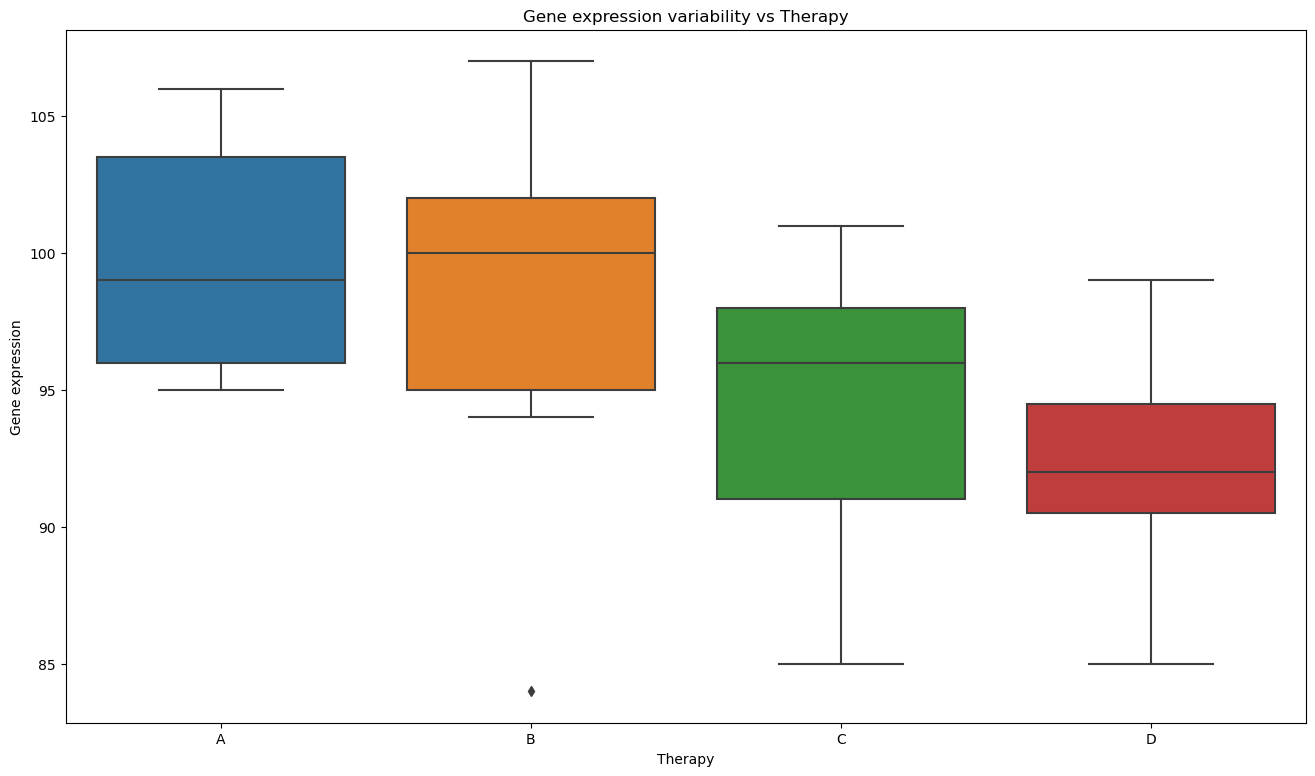

In [58]:
plt.figure(figsize=(16, 9))
sns.boxplot(x='Therapy', y='expr', data=df)

plt.title('Gene expression variability vs Therapy')
plt.xlabel('Therapy')
plt.ylabel('Gene expression')

### Perform ANOVA (manual approach)

In [59]:
therapy_list = df['Therapy'].unique()

In [60]:
# Number of groups and total number of observations

k = len(therapy_list)
n = len(df)

# Calculate group means and overall mean

group_means = [df[df['Therapy'] == therapy]['expr'].mean() for therapy in therapy_list]
overall_mean = df['expr'].mean()

# Calculate the between-group sum of squares (SSB)

SSB = sum(len(df[df['Therapy'] == therapy]['expr']) * (group_mean - overall_mean) ** 2 for therapy, group_mean in zip(therapy_list, group_means))

# Calculate the within-group sum of squares (SSW)

SSW = sum(sum((df[df['Therapy'] == therapy]['expr'] - group_mean) ** 2) for therapy, group_mean in zip(therapy_list, group_means))

# Calculate degrees of freedom

DFB = k - 1  # Between-group degrees of freedom
DFW = n - k  # Within-group degrees of freedom

# Calculate mean squares

MSB = SSB / DFB
MSW = SSW / DFW

# Calculate the F-statistic

F_statistic = MSB / MSW

# Calculate the p-value

p_value = stats.f.sf(F_statistic, DFB, DFW)

In [61]:
print(f"F-statistic: {F_statistic:.3f}")
print(f"P-value: {p_value:.5f}")

alpha = 0.05

if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference between the therapies.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference between the therapies.")

F-statistic: 8.037
P-value: 0.00015

Reject the null hypothesis: There is a significant difference between the therapies.


### Perform ANOVA using 'scipy.stats.f_oneway'

In [62]:
from scipy.stats import f_oneway

therapy_A = df[df['Therapy'] == 'A']['expr']
therapy_B = df[df['Therapy'] == 'B']['expr']
therapy_C = df[df['Therapy'] == 'C']['expr']
therapy_D = df[df['Therapy'] == 'D']['expr']


F_statistic, p_value = f_oneway(therapy_A, therapy_B, therapy_C, therapy_D)

print(f"F-statistic: {F_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference between the therapies.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference between the therapies.")

F-statistic: 8.03730248114399
P-value: 0.00015249722895229536

Reject the null hypothesis: There is a significant difference between the therapies.


### Perform ANOVA using 'statsmodels'

In [63]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('expr ~ Therapy', data=df).fit()
anova_results = anova_lm(model)

print(anova_results)

            df       sum_sq     mean_sq         F    PR(>F)
Therapy    3.0   560.716667  186.905556  8.037302  0.000152
Residual  56.0  1302.266667   23.254762       NaN       NaN


### Conclusion

---

We got that all different approaches of using analysis of variance showed identical results, which tells us that we did everything right when we calculated the f-statistic and p-value manually.